In [30]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.special import gamma
import matplotlib.pyplot as plt

In [22]:
def weighted_kde(data: np.ndarray, x_points: np.ndarray, dist_to_bounds: np.ndarray, kernel=None, alphas=None):

    n = len(data)
    bandwidth = 1.06 * np.std(data) * n ** (-1 / 5)

    if alphas is None:
        alphas = np.ones(n)

    bandwidths = bandwidth * alphas
    bandwidths = np.min([bandwidths, dist_to_bounds], axis=0)

    density = np.zeros_like(x_points)

    for i in range(n):
        if bandwidths[i]>0 and kernel is not None:
            current_density = kernel(data[i], x_points, bandwidths[i]).squeeze()

            # Ensure total density integrates properly
            density += current_density
        
        else : 
            idx = np.searchsorted(x_points, data[i])
            idx = np.clip(idx, 0, len(x_points) - 1)
            density[idx] += 1 / (x_points[1] - x_points[0])

    return density / n

# Sampling from KDE with adaptive bandwidth
def sample_weighted_kde(y, x, n_samples, a=0, b=1):
    """Samples from KDE with adaptive bandwidth."""
    cdf = np.cumsum(y) / np.sum(y)
    values = np.random.rand(n_samples)

    indices = np.searchsorted(cdf, values)
    inv_cdf = x[indices]

    inv_cdf = np.clip(inv_cdf, a, b)
    
    return inv_cdf


def preprocess_kernel_inputs(x,y,h):
    x = np.asarray(x)
    y = np.asarray(y)
    h = np.asarray(h)

    if x.ndim==0:
        x = np.array([x])
    if y.ndim==0:
        y = np.array([y])
    if h.ndim==0:
        h = np.array([h])
    if x.ndim==1:
        x = x.reshape(-1, 1)
    if y.ndim==1:
        y = y.reshape(-1, 1)
    if h.ndim==1:
        h = h.reshape(-1, 1)
    if x.shape[1] != y.shape[1]:
        raise ValueError("x and y must have the same number of dimensions.")
    if x.shape[0] != h.shape[0]:
        raise ValueError("x and h must have the same number of data points.")
    
    return x, y, h

def compute_scaled_differences(x, y, h):
    x, y, h = preprocess_kernel_inputs(x, y, h)
    x_exp = x[:, None, :]       # (n, 1, d)
    y_exp = y[None, :, :]       # (1, m, d)
    h_exp = h[:, None]          # (n, 1, 1)
    u = (x_exp - y_exp) / h_exp # (n, m, d)
    return u
def epanechnikov_kernel(x, y, h):
    x,y,h = preprocess_kernel_inputs(x, y, h)
    u = compute_scaled_differences(x, y, h)
    d = u.shape[-1]
    norms = np.linalg.norm(u, axis=-1)
    # Check if the points are admissible
    admissible = norms <= 1
    normalization_constant = (d+2)/ 2 * gamma((d + 2) / 2) / np.pi**(d / 2)
    return normalization_constant * (1 - norms ** 2) / (h**d) * admissible




In [5]:
data=pd.read_csv("../../../../data_matrix_grandchallenge_all.csv", sep=";")

In [6]:
data

,file,subtask,score,value,alg_name
0,BRATS_739.nii.gz,Task01_BrainTumour_L1,boundary_iou,0.035127,17111010008
1,BRATS_739.nii.gz,Task01_BrainTumour_L1,assd,33.662625,17111010008
2,BRATS_739.nii.gz,Task01_BrainTumour_L1,cldice,0.099519,17111010008
3,BRATS_739.nii.gz,Task01_BrainTumour_L1,dsc,0.067870,17111010008
4,BRATS_739.nii.gz,Task01_BrainTumour_L1,hd,163.633737,17111010008
...,...,...,...,...,...
322757,BRATS_525.nii.gz,Task01_BrainTumour_L3,hd,NaN,allan.kim01_all
322758,BRATS_525.nii.gz,Task01_BrainTumour_L3,hd_perc,NaN,allan.kim01_all
322759,BRATS_525.nii.gz,Task01_BrainTumour_L3,iou,0.000000,allan.kim01_all
322760,BRATS_525.nii.gz,Task01_BrainTumour_L3,masd,NaN,allan.kim01_all


In [8]:
instance=data[
    (data['score'] == 'iou') &
    (data['alg_name'] == 'ORippler') &
    (data['subtask'] == 'Task04_Hippocampus_L2')
]

In [11]:
x=instance['value']

In [14]:
x = x.dropna().to_numpy() 

In [16]:
a,b=0,1
dist_to_bounds = np.minimum(x - a, b - x)


In [17]:
dist_to_bounds

array([0.31199661, 0.32801822, 0.22533333, 0.21007984, 0.39660657,
       0.2634083 , 0.27326373, 0.26988072, 0.21410579, 0.30487239,
       0.28894231, 0.23271414, 0.2321513 , 0.1845175 , 0.28002378,
       0.19070905, 0.26454741, 0.29533941, 0.30518234, 0.29318449,
       0.2247771 , 0.22348298, 0.2404661 , 0.26353791, 0.32351544,
       0.19601508, 0.2893401 , 0.22410033, 0.16825095, 0.33089214,
       0.2393617 , 0.19520074, 0.22157093, 0.24401914, 0.186223  ,
       0.20808511, 0.23415133, 0.19833088, 0.2186255 , 0.26414166,
       0.29243597, 0.23618582, 0.24941452, 0.27355072, 0.2373494 ,
       0.20570866, 0.23783784, 0.41635489, 0.29781421, 0.20194647,
       0.24522761, 0.26490898, 0.28018223, 0.34486071, 0.23558559,
       0.2510383 , 0.18533815, 0.20702958, 0.2606383 , 0.25568744,
       0.22331461, 0.34084881, 0.24219537, 0.45474614, 0.23618582,
       0.21038961, 0.17761989, 0.2346136 , 0.23406721, 0.19192964,
       0.33114919, 0.30196937, 0.2171123 , 0.28767123, 0.34515

In [23]:
kde_y = weighted_kde(
    data=x,
    x_points= np.linspace(0, 1, 600),
    dist_to_bounds=dist_to_bounds,
    kernel=epanechnikov_kernel
)


In [41]:
kde_samples = sample_weighted_kde(
    y=kde_y,
    x=np.linspace(0, 1, 600),
    n_samples=150,
    a=0,
    b=1
)


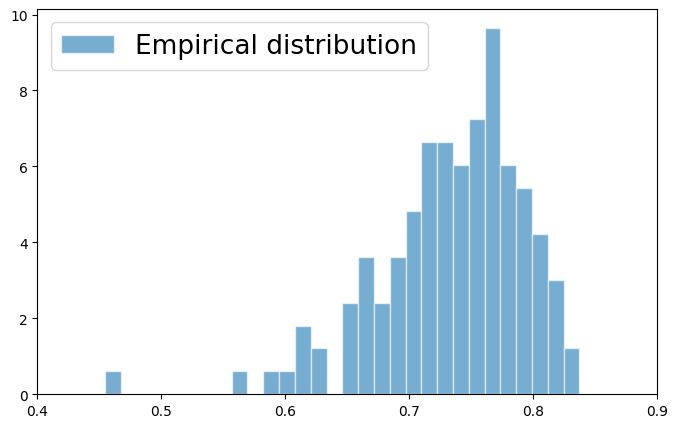

In [74]:
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, alpha=0.6, edgecolor="white", label="Empirical distribution")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.legend(fontsize=19, loc='upper left')
plt.xlim(0.4, 0.9)
plt.show()


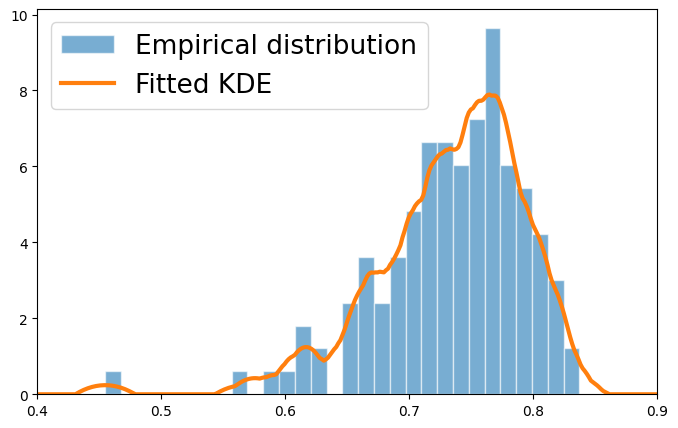

In [73]:
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, alpha=0.6, label="Empirical distribution",edgecolor="white")
plt.plot(np.linspace(0, 1, 600), kde_y, linewidth=3, label="Fitted KDE")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.xlim(0.4,0.9)
plt.legend(fontsize=19, loc= "upper left")
plt.show()


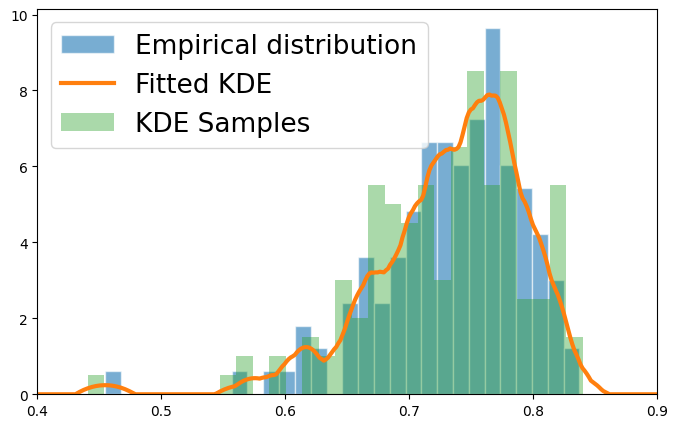

In [72]:
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, alpha=0.6, label="Empirical distribution", edgecolor="white")
plt.plot(np.linspace(0, 1, 600), kde_y, linewidth=3, label="Fitted KDE")
plt.hist(kde_samples, bins=30, density=True, alpha=0.4, label="KDE Samples")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.legend(fontsize=19, loc="upper left")
plt.xlim(0.4,0.9)

plt.show()
